### Deep Convolutional GANs (DCGANs) for CIFAR-10

#### Summary of how DCAGNs build on top of the basic GANs

1. Rather than fully-connected or pooling layers, we use strided convoltuions (for discriminator) and transposed convolutions (for generator). 
2. We use batch-normalization layers in both generator and discriminator to faster and more stable training. 
3. We use LeakyReLU as the alternative of ReLU to prevent the zero learning problem of ReLU. 

#### Git repo

In [ ]:
!git clone https://github.com/Daisuke0713/ANN-final.git
%cd ./ANN-final/DCGANs

#### Libraries

In [1]:
import numpy as np
import time
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras, random, nn
from tensorflow import data
from keras import Model, Sequential
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.optimizers import Adam
from keras import initializers 
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten, BatchNormalization, ReLU, LeakyReLU, Dropout, InputLayer

2023-04-15 14:18:53.880078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### GPU/CPU Settings

In [2]:
gpu_device = tf.test.gpu_device_name()
cpu_device = '/cpu:0'
# set CPU the device for now
device = cpu_device

2023-04-15 14:18:58.998817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
if gpu_device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(gpu_device))

#### Config Hyper-parameters

In [3]:
epochs = 10
batch_size = 32
latent_dim = 100
learning_rate = 1e-4

#### Data Pre-processing

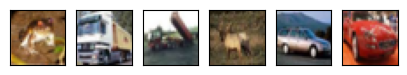

In [5]:
# import the data
(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()
x_train = np.concatenate((x_train, x_test), axis = 0)/255.

# check some images
fig, axes = plt.subplots(figsize=(5, 1), nrows=1, ncols=6, sharey=True, sharex=False)
for i in range(6):
    axes[i].xaxis.set_visible(False)
    axes[i].yaxis.set_visible(False)
    im = axes[i].imshow(x_train[i])

#### Split into batches

In [6]:
# split data into batches
def split_batch(image_data, batch_size):
    size = len(image_data)
    return (data.Dataset.from_tensor_slices(image_data).shuffle(size).batch(batch_size))
x_train = split_batch(x_train, batch_size)

#### Define GANs

Generator

In [92]:
generator = Sequential([
    # input
    Dense(units=8*8*512, input_shape=(latent_dim,)),
    Reshape((8,8,512)),
    # conv 1
    Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same'),
    BatchNormalization(),
    ReLU(max_value=0.2),
    # conv 2
    Conv2DTranspose(filters=256, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(max_value=0.2),
    # conv 3
    Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(max_value=0.2),
    # final tanh    
    Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding='same', activation='tanh')
])

Discriminator

In [93]:
discriminator = Sequential([
    # conv 1
    Conv2D(filters=64, kernel_size=3, strides=2, padding='same', input_shape=(32,32,3)),
    LeakyReLU(0.2),
    # conv 2
    Conv2D(filters=128, kernel_size=3, strides=2, padding='same'),
    LeakyReLU(0.2),
    # conv 3
    Conv2D(filters=256, kernel_size=3, strides=2, padding='same'),
    LeakyReLU(0.2),
    # output
    Flatten(),
    Dense(1, activation='sigmoid')
])

Merge G and D

In [88]:
discriminator.compile(optimizer=Adam(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
discriminator.trainable = False
gan = Sequential([
    generator, 
    discriminator
])
gan.compile(optimizer=Adam(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

#### Train GANs

In [89]:
def generate():
    with tf.device(device):
        ramdom_vector_z = np.random.normal(loc=0, scale=1, size=(16, latent_dim))
        generated = generator(ramdom_vector_z)
        return generated

def save_img(imgs, filename=None):
    imgs = (imgs + 1.)/2.
    plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(imgs[i,:,:,:])
        plt.axis('off')
    plt.savefig(f'./images/{filename}.png')

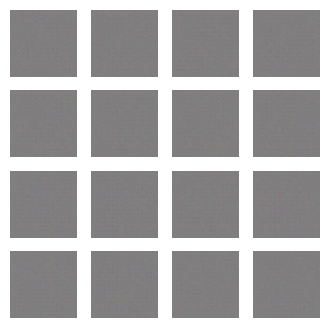

In [90]:
save_img(generate())

In [ ]:
# labels
real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

with tf.device(device_name=device):
    for epoch in range(epochs):
        batch = 0
        for real_x in x_train:
            '''discriminator'''

            # train on real data
            d_loss_real = discriminator.train_on_batch(x=real_x, y=real)

            # train on fake data
            z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
            fake_x = generator.predict_on_batch(x=z)
            d_loss_fake = discriminator.train_on_batch(x=fake_x, y=fake)
            d_loss = np.mean(d_loss_real + d_loss_fake)

            '''generator'''
            g_loss = gan.train_on_batch(x=z, y=real)

            batch += 1
            print(f'[Progress: {100*batch//len(x_train)}%] Epoch: {epoch}', end='\r')
        print(f'Epoch: {epoch}, Loss G: {g_loss[-1]:.3f}, Loss D: {d_loss:.3f}')
        
        # sample and save images
        if epoch % 10 == 0:
            save_img(generate(), f'cifar_epoch{epoch}_batch{batch_size}_latent{latent_dim}')

gan.save('./saved_models/model')

In [ ]:
!zip -r ./images.zip images